In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import genjax
import genjax.prox as prox
from genjax import Normal, TFPUniform
from math import pi as π

sns.set_theme(style="white")

# Pretty printing.
console = genjax.pretty(width=70)

# Reproducibility.
key = jax.random.PRNGKey(314159)

Let's start by defining a model generative program. This example is from [Alex Lew's 2020 LAFI talk on a related language called MetaPPL](https://popl20.sigplan.org/details/lafi-2020/14/MetaPPL-Inference-Algorithms-as-First-Class-Generative-Models).

In [3]:
@genjax.gen
def model():
    x = Normal(0.0, 10.0) @ "x"
    y = Normal(0.0, 10.0) @ "y"
    z = Normal(x**2 + y**2, 1.0) @ "z"
    return z

In [4]:
key, sub_keys = genjax.slash(key, 300)
_, trs = jax.vmap(model.simulate, in_axes=(0, None))(sub_keys, ())
chm = trs.strip()

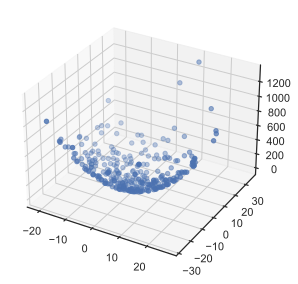

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(chm["x"], chm["y"], chm["z"])
plt.show()

When we use `prox.chm_dist` (which is shorthand for `prox.ChoiceMapDistribution`) - we're creating a new generative function whose internal proposal `q` can be changed.

In [6]:
prox_model = prox.chm_dist(model, selection=genjax.select("x", "y"), custom_q=None)
prox_model

ChoiceMapDistribution
├── p
│   └── BuiltinGenerativeFunction
│       └── source
│           └── <function model>
├── selection
│   └── BuiltinSelection
│       └── trie
│           └── Trie
│               ├── :x
│               │   └── AllSelection
│               └── :y
│                   └── AllSelection
└── custom_q
    └── (const) None

Above, we're keeping the default internal proposal `q` by not providing a `custom_q`. This means that `prox_model` inherits `q` from `model`.

The resulting `prox_model` object is something called a `ChoiceMapDistribution` - it's an approximate distribution over the random choices at the addresses we pass in via `selection`.

We specified `"x"` and `"y"` - which means we are asking for a distribution which is the **marginal** of the full joint of `model`.

$$
P(x, y) = \int P(x, y, z) \ dz
$$

As we know, this is the source of the intractability of Bayesian inference in the first place! So how do we get around this?

In [7]:
key, tr = prox_model.simulate(key, ())
tr

DistributionTrace
├── gen_fn
│   └── ChoiceMapDistribution
│       ├── p
│       │   └── BuiltinGenerativeFunction
│       │       └── source
│       │           └── <function model>
│       ├── selection
│       │   └── BuiltinSelection
│       │       └── trie
│       │           └── Trie
│       │               ├── :x
│       │               │   └── AllSelection
│       │               └── :y
│       │                   └── AllSelection
│       └── custom_q
│           └── (const) None
├── args
│   └── tuple
├── value
│   └── BuiltinChoiceMap
│       └── trie
│           └── Trie
│               ├── :x
│               │   └── ValueChoiceMap
│               │       └── value
│               │           └──  f32[]
│               └── :y
│                   └── ValueChoiceMap
│                       └── value
│                           └──  f32[]
└── score
    └──  f32[]

Another way to produce an approximate density is to condition a normalized distribution (producing an unnormalized one), then approximately normalize.

Prox provides a way to express these densities using `prox.Target`.

In [8]:
constraint = genjax.choice_map({"z": 4.0})
constraint

BuiltinChoiceMap
└── trie
    └── Trie
        └── :z
            └── ValueChoiceMap
                └── value
                    └── (const) 4.0

In [9]:
target = prox.target(model, (), constraint)
target

Target
├── p
│   └── BuiltinGenerativeFunction
│       └── source
│           └── <function model>
├── args
│   └── tuple
└── constraints
    └── BuiltinChoiceMap
        └── trie
            └── Trie
                └── :z
                    └── ValueChoiceMap
                        └── value
                            └── (const) 4.0

A `Target` is an unnormalized distribution. The standard inference library in Prox exposes inference algorithms which are themselves approximate densities, whose interfaces accept `Target` instances and perform approximate normalization.

In [10]:
prox_is = prox.importance(50, None)
prox_is

Importance
├── num_particles
│   └── (const) 50
└── proposal
    └── (const) None

The default variant of `prox.importance` utilizes sampling importance resampling with no custom proposal. Let's examine the quality of the posterior approximation.

In [11]:
key, sub_keys = genjax.slash(key, 1000)
_, tr = jax.jit(jax.vmap(prox_is.simulate, in_axes=(0, None)))(sub_keys, (target,))
chm = tr.get_retval()
chm

BuiltinChoiceMap
└── trie
    └── Trie
        ├── :x
        │   └── ValueChoiceMap
        │       └── value
        │           └──  f32[1000]
        └── :y
            └── ValueChoiceMap
                └── value
                    └──  f32[1000]

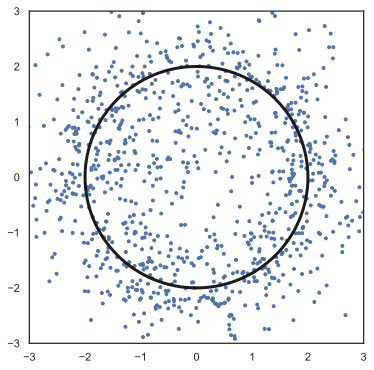

In [12]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
circle = plt.Circle((0, 0), 2.0, color="k", fill=False, lw=3)
ax.scatter(chm["x"], chm["y"], marker=".")
ax.add_artist(circle)

We can improve the quality of the approximation by providing a custom proposal.

In [13]:
@genjax.gen
def custom_q(target):
    chm = target.constraints
    z = chm["z"]
    θ = TFPUniform(0.0, 2 * π) @ "θ"
    x = Normal(jnp.sqrt(z) * jnp.cos(θ), 0.2) @ "x"
    y = Normal(jnp.sqrt(z) * jnp.sin(θ), 0.2) @ "y"

When run within the sampling importance resampling routine, the custom proposal is allowed to inspect the observed data (here, `chm`).

Note that `custom_q` samples auxiliary randomness for the `"θ"` address - to correctly define the importance weight density ratio, we need to marginalize out `"θ"`.

In [14]:
prox_custom_q = prox.chm_dist(custom_q, selection=genjax.select("x", "y"))

In [15]:
prox_is = prox.importance(50, prox_custom_q)
prox_is

Importance
├── num_particles
│   └── (const) 50
└── proposal
    └── ChoiceMapDistribution
        ├── p
        │   └── BuiltinGenerativeFunction
        │       └── source
        │           └── <function custom_q>
        ├── selection
        │   └── BuiltinSelection
        │       └── trie
        │           └── Trie
        │               ├── :x
        │               │   └── AllSelection
        │               └── :y
        │                   └── AllSelection
        └── custom_q
            └── (const) None

In [16]:
key, sub_keys = genjax.slash(key, 1000)
_, tr = jax.jit(jax.vmap(prox_is.simulate, in_axes=(0, None)))(sub_keys, (target,))
chm = tr.get_retval()
chm

BuiltinChoiceMap
└── trie
    └── Trie
        ├── :x
        │   └── ValueChoiceMap
        │       └── value
        │           └──  f32[1000]
        └── :y
            └── ValueChoiceMap
                └── value
                    └──  f32[1000]

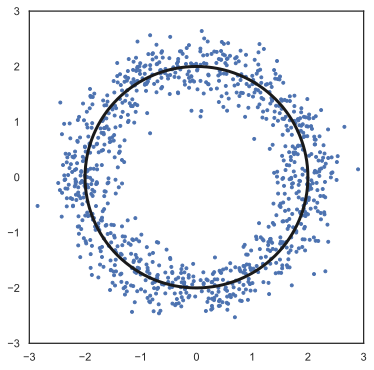

In [17]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
circle = plt.Circle((0, 0), 2.0, color="k", fill=False, lw=3)
ax.scatter(chm["x"], chm["y"], marker=".")
ax.add_artist(circle)

For both variants, we can estimate the log evidence and compare the value - the conditional log evidence ratio is often used for Bayesian model selection.

## Trace types for absolute continuity diagnosis

In the preceding sections, we were careful to identify exactly what subsets of random variables we wished to target with proposals and we lined addresses up accordingly. However, as the complexity of an approximate density tower increases - it would be useful to have automated tooling to check for support mismatches.

GenJAX generative functions support a form of gradual typing based upon [Lew et al, 2020](https://dl.acm.org/doi/10.1145/3371087) - providing a conservative representation of the support of the distribution which a generative function represents.

In [18]:
model.get_trace_type()

BuiltinTraceType
├── trie
│   └── Trie
│       ├── :x
│       │   └── ℝ ()
│       ├── :y
│       │   └── ℝ ()
│       └── :z
│           └── ℝ ()
└── retval_type
    └── ℝ ()

In [19]:
custom_q.get_trace_type(target)

BuiltinTraceType
├── trie
│   └── Trie
│       ├── :θ
│       │   └── ℝ ()
│       ├── :x
│       │   └── ℝ ()
│       └── :y
│           └── ℝ ()
└── retval_type
    └── ϕ (empty)

What happens if we transform `custom_q` to internally marginalize `"θ"`?

In [20]:
prox_custom_q.get_trace_type(target)

BuiltinTraceType
├── trie
│   └── Trie
│       ├── :x
│       │   └── ℝ ()
│       └── :y
│           └── ℝ ()
└── retval_type
    └── ϕ (empty)

There's an interface for trace types called `on_support`, which checks if a trace type is on the support of another trace type.

In [21]:
t1 = prox_custom_q.get_trace_type(target)
t2 = model.get_trace_type()
check, mismatch_tree = t1.on_support(t2)
mismatch_tree

Trie
└── :z
    └── tuple
        ├── (const) None
        └── ℝ ()

This interface returns two values: the first is a `bool` indicating if the first is on the support of the second, and the second is a "mismatch" tree which shows what addresses violate the check.

Every address which violates the check gets a `tuple` showing the trace type for the first type against the second type at that address - above, we see that the proposal doesn't provide a choice at `"z"`, the first element is `None` in the tuple.

GenJAX's Prox implementation takes advantage of this gradual type system to perform static support checks at compile time, and return errors if mismatches occur. Observe:

In [22]:
@genjax.gen
def no_match(target):
    θ = Normal(0.0, 1.0) @ "θ"


try:
    prox.static_check_supports(target, no_match)
except Exception as e:
    console.print(e)

Trace type mismatch.
Given target: Target(p=BuiltinGenerativeFunction(source=<function model at 0x16a2de2a0>), args=(), constraints=BuiltinChoiceMap(trie=Trie(inner={'z': ValueChoiceMap(value=4.0)})))
Proposal: BuiltinGenerativeFunction(source=<function no_match at 0x16a2c7ce0>)

Absolute continuity failure at the following addresses:
Trie(inner={'x': (Reals(shape=()), None), 'y': (Reals(shape=()), None), 'θ': (None, Reals(shape=()))})

## Inference diagnostics for Prox distributions

We started with a model $P(x, y, z)$ and then we constructed a posterior inference problem by creating a `Target` with constrained $z$. 

We then utilized default sampling importance resampling via `prox.importance` to construct an approximate normalized density. Our results for that initial variant were not so good - so we improved it by creating a custom proposal for `prox.importance` - but our custom proposal utilized auxiliary latent variables.

To correctly compute the importance weight ratios including these auxiliary latents, we introduced a meta-proposal which we used to approximately marginalize out the new auxiliary latents.